In [1]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets
import torch.nn.functional as F

In [28]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

/Users/kristinanikolic/opt/anaconda3/envs/CV/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: " + str(device))

Using: cpu


In [4]:
# Define main data directory
DATA_DIR = 'tiny-imagenet-200-test' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

<b>Helper functions for image show</b>

In [5]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = np.random.randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

def show_image_pair(dataloader):
    dataiter = iter(dataloader)
    images1, images2, labels = dataiter.next()
    random_num = np.random.randint(0, len(images1)-1)
    imshow(images1[random_num])
    imshow(images2[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images1[random_num].shape}')

In [6]:
#preprocessing and loading the dataset
class SiameseDataset(Dataset):
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.train_df=pd.read_csv(training_csv)
        self.train_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        # getting the image path
        img1 = self.train_df.iat[index,0]
        class1 = img1.split('_')[0]
        image1_path=os.path.join(self.train_dir,class1)
        image1_path=os.path.join(image1_path,'images')
        image1_path=os.path.join(image1_path,img1)

        img2 = self.train_df.iat[index,1]
        class2 = img2.split('_')[0]
        image2_path=os.path.join(self.train_dir,class2)
        image2_path=os.path.join(image2_path,'images')
        image2_path=os.path.join(image2_path,img2)

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        # img1.transpose((2, 0, 1))
        # img2.transpose((2, 0, 1))
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        label = torch.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))
        smpl = [img0, img1, label]
        return smpl

    def __len__(self):
        return len(self.train_df)

In [7]:
Image.open('tiny-imagenet-200/train/n03447447/images/n03447447_2.JPEG').mode


'L'

<b>Data Loders</b>

In [9]:
# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform=None):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

Validation dataset

In [10]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [10]:
# Open and read val annotations text file
fp = open(os.path.join(DATA_DIR, 'wnids.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
#classes_enum = {}
classes = []
for line in data:
    words = line.split('\n')
    #classes_enum[words[0]] = words[1]
    classes.append(words[0])
fp.close()

class_50 = classes[0:50]
class_20 = classes[0:20]
class_2 = classes[0:2]
# Display first 10 entries of resulting class list
{k for k in class_50[0:10]}

{'n01641577',
 'n02124075',
 'n02802426',
 'n03970156',
 'n04067472',
 'n04099969',
 'n04540053',
 'n07749582',
 'n07920052',
 'n09246464'}

In [11]:
first_img = []
second_img = []
label = []
pairs_per_class = 19
class_data = class_20
stop = 2*pairs_per_class
# select positive pairs, every class has pairs_per_class pairs, consecutive
for clas in class_data:
    img_dir = os.path.join(TRAIN_DIR, clas)
    fp = open(os.path.join(img_dir, clas + '_boxes.txt'), 'r')
    data = fp.readlines()
    for i in range(0,stop,2):
        ok1 = False
        while not ok1:
            choise = data[i].split('\t')[0]
            path  = os.path.join(img_dir,'images')
            path = os.path.join(path,choise)
            if(os.path.exists(path) and Image.open(path).mode=='RGB'):
                first_img.append(choise)
                ok1 = True
            else:
                i = i+1
                stop = stop+1
        ok2 = False
        while not ok2:
            choise = data[i+1].split('\t')[0]
            path  = os.path.join(img_dir,'images')
            path = os.path.join(path,choise)
            if(os.path.exists(path) and Image.open(path).mode=='RGB'):
                second_img.append(choise)
                ok2 = True
            else:
                i = i+1
                stop = stop+1
        label.append('1')
    fp.close()

# print(first_img)
# print(second_img)
# print(label)

# select negative pairs
for t in range(1):
    for i in range(len(class_data)):
        img_dir1 = os.path.join(TRAIN_DIR, class_data[i])
        fp1 = open(os.path.join(img_dir1, class_data[i] + '_boxes.txt'), 'r')
        data1 = fp1.readlines()
        for j in range(i+1, len(class_data)):
            img_dir2 = os.path.join(TRAIN_DIR, class_data[j])
            fp2 = open(os.path.join(img_dir2, class_data[j] + '_boxes.txt'), 'r')
            data2 = fp2.readlines()

            ok1 = False
            while not ok1:
                choise = data1[np.random.randint(0,2*pairs_per_class)].split('\t')[0]
                path  = os.path.join(img_dir1,'images')
                path = os.path.join(path,choise)
                if(os.path.exists(path) and Image.open(path).mode=='RGB'):
                    first_img.append(choise)
                    ok1 = True

            ok2 = False
            while not ok2:
                choise = data2[np.random.randint(0,2*pairs_per_class)].split('\t')[0]
                path = os.path.join(img_dir2,'images')
                path = os.path.join(path,choise)
                if(os.path.exists(path) and Image.open(path).mode=='RGB'):
                    second_img.append(choise)
                    ok2 = True                
            
            label.append('0')

            fp2.close()
        fp1.close()

print(len(first_img))
print(len(second_img))
print(len(label))

638
638
638


In [12]:
new_data = {'First': first_img, 'Second': second_img, 'Label': label}
df = pd.DataFrame(new_data)
df.to_csv('data20.csv', index=False, header=None)

In [11]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [12]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform_pretrain = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.5, 0.5, 0.5], 
                            std=[0.5, 0.5, 0.5])
])

simple = T.Compose([T.ToTensor(),  # Converting cropped images to tensors
])

In [13]:
# Define batch size for DataLoaders
batch_size = 64

# Create DataLoaders for pre-trained models (normalized based on specific requirements)
train_loader = generate_dataloader(TRAIN_DIR, "train")

val_loader= generate_dataloader(val_img_dir, "val")

In [29]:
train_data = SiameseDataset('train2000.csv',TRAIN_DIR,simple)
batch_size = 128

if use_cuda:
    kwargs = {"pin_memory": True, "num_workers": 1}
else:
    kwargs = {}

# Wrap image dataset (defined above) in dataloader 
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

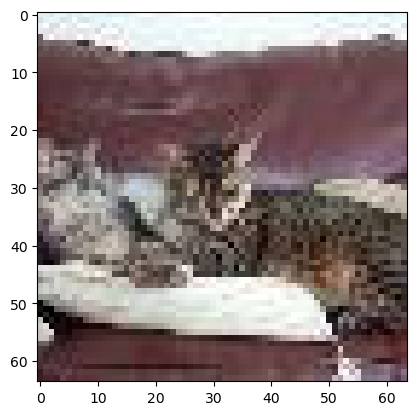

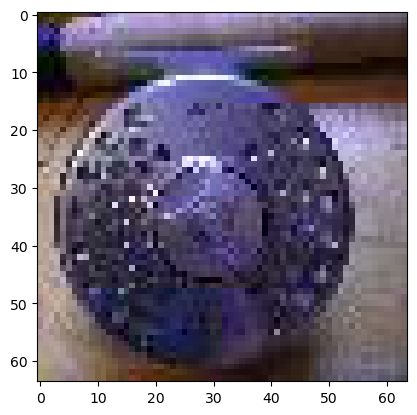

Label: tensor([0.]), Shape: torch.Size([3, 64, 64])


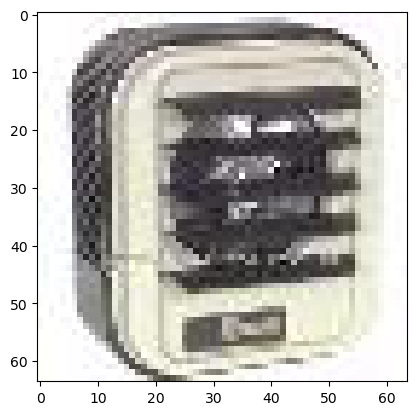

Label: 151, Shape: torch.Size([3, 64, 64])


In [25]:
#show_batch(val_loader)
show_image_pair(train_dataloader)
show_image(train_loader)

<b>Network definition</b>

In [18]:
#create a siamese network
class SiameseNetworkLong(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [17]:
#create a siamese network
class SiameseNetworkSimple(nn.Module):
    def __init__(self):
        super(SiameseNetworkSimple, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(10, 120, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(20280,1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [18]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean(
            (label) * torch.pow(euclidean_distance, 2)
            + (1-label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )/2

        return loss_contrastive
    # VEROVATNO GRESKA za batch
    # pairwise distance -> keepdim na false

In [23]:
class BinaryLoss(torch.nn.Module):
    """
    Binary loss function.
    Based on:
    """
    
    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Epoch 1
 Current loss 0.8042513132095337

Epoch 1
 Current accuracy 0.5057666633702531

Epoch 2
 Current loss 0.6353334784507751

Epoch 2
 Current accuracy 0.49209478837025317

Epoch 3
 Current loss 0.6056326627731323

Epoch 3
 Current accuracy 0.5004635581487342

Epoch 4
 Current loss 0.5728201270103455

Epoch 4
 Current accuracy 0.49416534810126583

Epoch 5
 Current loss 0.6014899015426636

Epoch 5
 Current accuracy 0.48586456685126583

Epoch 6
 Current loss 0.543065071105957

Epoch 6
 Current accuracy 0.4578162084651899

Epoch 7
 Current loss 0.5820872783660889

Epoch 7
 Current accuracy 0.45559112935126583

Epoch 8
 Current loss 0.5545689463615417

Epoch 8
 Current accuracy 0.45305083069620256

Epoch 9
 Current loss 0.5694426894187927

Epoch 9
 Current accuracy 0.4597507911392405

Epoch 10
 Current loss 0.5927853584289551

Epoch 10
 Current accuracy 0.4523585838607595

Epoch 11
 Current loss 0.6155179142951965

Epoch 11
 Current accuracy 0.44577605814873417

Epoch 12
 Current loss 

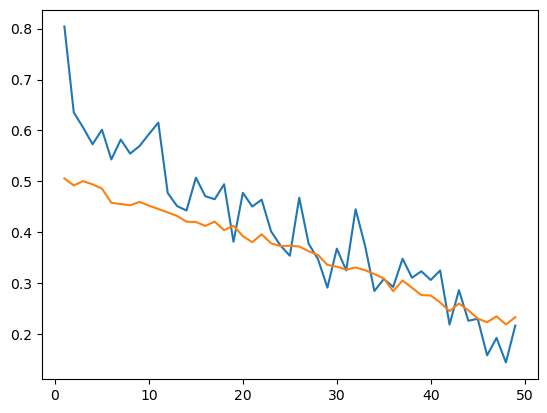

In [36]:
# Declare Siamese Network
net = SiameseNetworkSimple()
net = net.to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)
# Epochs
epochs = 50
#train the model
def train():
    loss=[] 
    counter=[]
    acc = []
    iteration_number = 0
    for epoch in range(1,epochs):
        acc_ep = 0
        items = 0
        batch = 0
        for batch_id, smpl in enumerate(train_dataloader):
            img0, img1, label = smpl[0], smpl[1], smpl[2]
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
            label_t = euclidean_distance<0.5
            items = items + len(label)
            batch = batch + 1
            acc_ep = acc_ep + accuracy_score(label, label_t)
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        print("Epoch {}\n Current accuracy {}\n".format(epoch,acc_ep/batch))
        iteration_number += 1
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
        acc.append(acc_ep/batch)
    plt.plot(counter, loss) 
    plt.plot(counter, acc)  
    return net
#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully") 